In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow.keras as keras
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

# Load the data
data = pd.read_csv("Load_data_new.csv")
data["Time"] = pd.to_datetime(data["Time"])
data.set_index("Time", inplace=True)

# Replace textual descriptions with numerical values
replacement_dict = {
    "no clouds": 0,
    "2/10–3/10.": 3,
    "7/10 – 8/10.": 8,
    "10/10.": 10,
    "4/10.": 4,
    "5/10.": 5,
    "Sky obscured by fog and/or other meteorological phenomena.": 10,
}
data['total_cloud_cover[from ten]'] = data['total_cloud_cover[from ten]'].replace(replacement_dict).astype('float64')

# Create new features for time-related variables
data['hour'] = data.index.hour
data['day_of_year'] = data.index.dayofyear
data['day_of_month'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year


#Create lag features
num_lags = 3
for i in range(1, num_lags+1):
    data[f'electricity_consumption_lag_{i}'] = data['electricity_demand_values[kw]'].shift(i)
    data[f'heat_consumption_lag_{i}'] = data['heat_demand_values[kw]'].shift(i)

# Rolling window statistics
data['electricity_rolling_mean'] = data['electricity_demand_values[kw]'].rolling(window=3).mean()
data['heat_rolling_mean'] = data['heat_demand_values[kw]'].rolling(window=3).mean()

# Remove rows with NaN values
data = data.dropna()

# Save the preprocessed data
data.to_csv("preprocessed_data1.csv", index=True) 

In [19]:
# Normalize the data
data = data.reset_index()
data = data.drop(columns=["Time"])
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data)


In [21]:
#Split the dataset into training, validation, and testing sets
train_size = int(len(data_norm) * 0.6)
val_size = int(len(data_norm) * 0.2)
test_size = len(data_norm) - train_size - val_size

train, val, test = data_norm[:train_size, :], data_norm[train_size:train_size+val_size, :], data_norm[train_size+val_size:, :]


In [22]:
# Generate input and output data
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), :-2])
        dataY.append(dataset[i + look_back, -2:])
    return np.array(dataX), np.array(dataY)

look_back = 24
X_train, y_train = create_dataset(train, look_back)
X_val, y_val = create_dataset(val, look_back)
X_test, y_test = create_dataset(test, look_back)


In [23]:
# Define the CNN model architecture
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2))

# Adjust learning rate with scheduling
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_val, y_val), verbose=2)


Epoch 1/50
573/573 - 24s - loss: 0.1361 - val_loss: 0.0133 - 24s/epoch - 42ms/step
Epoch 2/50
573/573 - 12s - loss: 0.0190 - val_loss: 0.0103 - 12s/epoch - 22ms/step
Epoch 3/50
573/573 - 12s - loss: 0.0127 - val_loss: 0.0082 - 12s/epoch - 22ms/step
Epoch 4/50
573/573 - 13s - loss: 0.0103 - val_loss: 0.0081 - 13s/epoch - 22ms/step
Epoch 5/50
573/573 - 12s - loss: 0.0090 - val_loss: 0.0075 - 12s/epoch - 22ms/step
Epoch 6/50
573/573 - 12s - loss: 0.0082 - val_loss: 0.0072 - 12s/epoch - 22ms/step
Epoch 7/50
573/573 - 13s - loss: 0.0074 - val_loss: 0.0078 - 13s/epoch - 22ms/step
Epoch 8/50
573/573 - 12s - loss: 0.0069 - val_loss: 0.0067 - 12s/epoch - 22ms/step
Epoch 9/50
573/573 - 12s - loss: 0.0061 - val_loss: 0.0057 - 12s/epoch - 22ms/step
Epoch 10/50
573/573 - 13s - loss: 0.0056 - val_loss: 0.0048 - 13s/epoch - 23ms/step
Epoch 11/50
573/573 - 13s - loss: 0.0050 - val_loss: 0.0038 - 13s/epoch - 22ms/step
Epoch 12/50
573/573 - 13s - loss: 0.0046 - val_loss: 0.0043 - 13s/epoch - 22ms/step
E

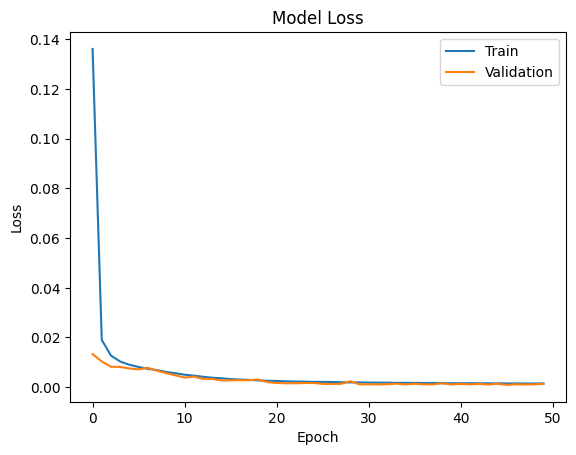

In [24]:
# Plot training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [25]:
# Evaluate and make predictions
y_pred = model.predict(X_test)

430/430 [==============================] - 3s 5ms/step


In [26]:
# Calculate evaluation metrics 
rmse_electricity = np.sqrt(mean_squared_error(y_test[:, 0], y_pred[:, 0]))
rmse_heat = np.sqrt(mean_squared_error(y_test[:, 1], y_pred[:, 1]))
print(f"RMSE for electricity demand: {rmse_electricity}")
print(f"RMSE for heat demand: {rmse_heat}")
mae_electricity = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_heat = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
r2_electricity = r2_score(y_test[:, 0], y_pred[:, 0])
r2_heat = r2_score(y_test[:, 1], y_pred[:, 1])
print(f"R-squared for electricity demand: {r2_electricity}")
print(f"R-squared for heat demand: {r2_heat}")
print(f"MAE for electricity demand: {mae_electricity}")
print(f"MAE for heat demand: {mae_heat}")


RMSE for electricity demand: 0.04935039955980938
RMSE for heat demand: 0.04084099440861552
R-squared for electricity demand: 0.9171692292145958
R-squared for heat demand: 0.9605335175515507
MAE for electricity demand: 0.03444037582635018
MAE for heat demand: 0.02631835834287477


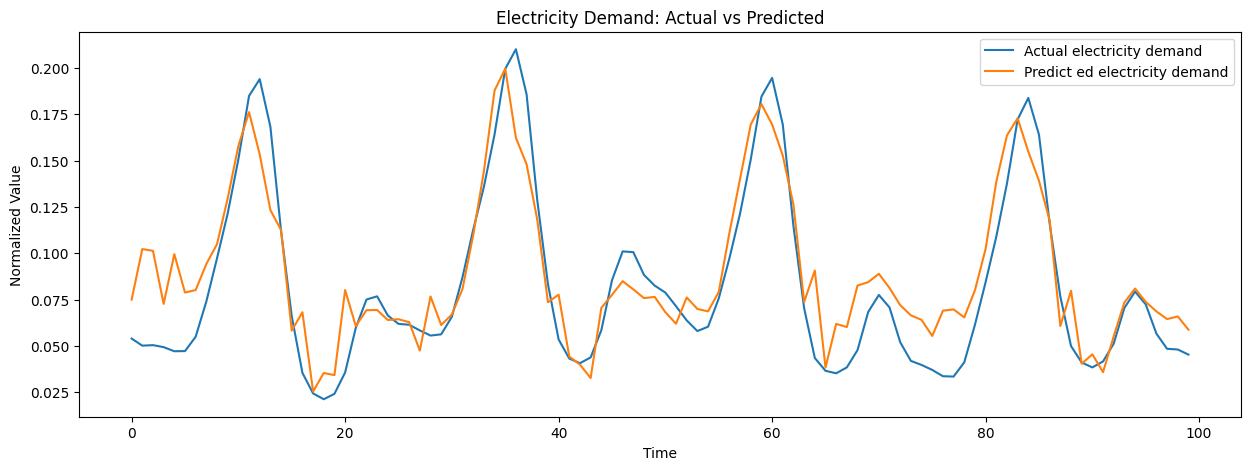

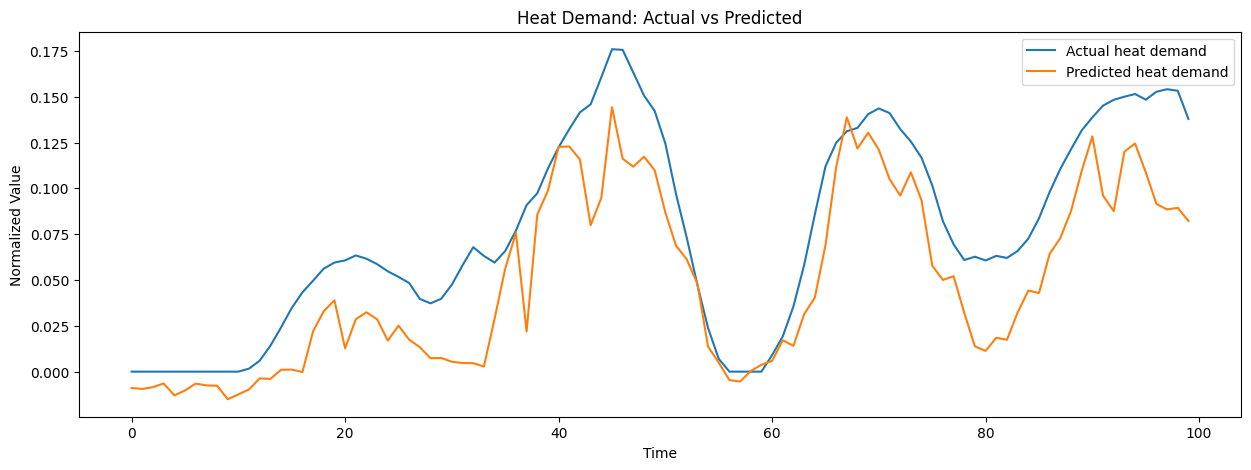

In [27]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(y_test[:100, 0], label="Actual electricity demand")
plt.plot(y_pred[:100, 0], label="Predict ed electricity demand")
plt.title("Electricity Demand: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(y_test[:100, 1], label="Actual heat demand")
plt.plot(y_pred[:100, 1], label="Predicted heat demand")
plt.title("Heat Demand: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

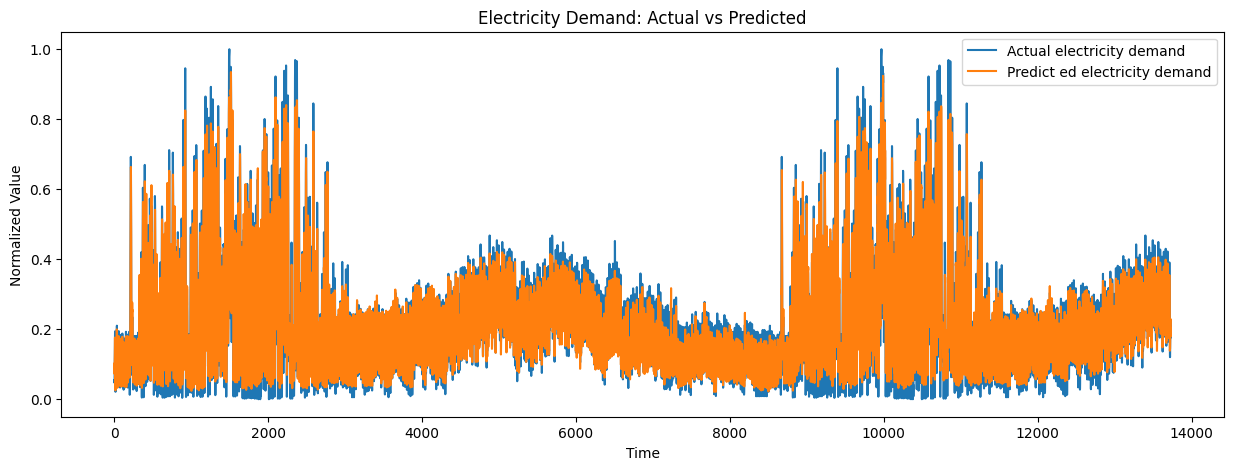

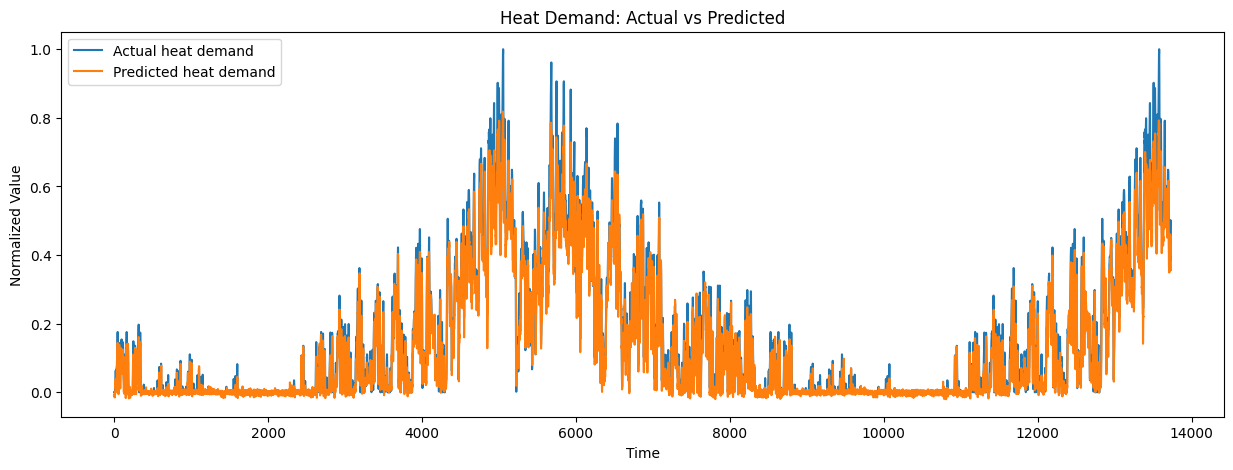

In [28]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(y_test[:14000, 0], label="Actual electricity demand")
plt.plot(y_pred[:14000, 0], label="Predict ed electricity demand")
plt.title("Electricity Demand: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:14000, 1], label="Actual heat demand")
plt.plot(y_pred[:14000, 1], label="Predicted heat demand")
plt.title("Heat Demand: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

In [29]:
# Print some actual and predicted values for comparison
i_range = range(13731)  

for i in i_range:
    print(f"Index {i}: Actual [electricity, heat] = [{y_test[i, 0]:.2f}, {y_test[i, 1]:.2f}], Predicted [electricity, heat] = [{y_pred[i, 0]:.2f}, {y_pred[i, 1]:.2f}]")
    

Index 0: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.07, -0.01]
Index 1: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.10, -0.01]
Index 2: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.10, -0.01]
Index 3: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.07, -0.01]
Index 4: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.10, -0.01]
Index 5: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.08, -0.01]
Index 6: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.08, -0.01]
Index 7: Actual [electricity, heat] = [0.07, 0.00], Predicted [electricity, heat] = [0.09, -0.01]
Index 8: Actual [electricity, heat] = [0.10, 0.00], Predicted [electricity, heat] = [0.10, -0.01]
Index 9: Actual [electricity, heat] = [0.12, 0.00], Predicted [electricity, heat] = [0.13, -0.02]
Index 10: Actual [el

In [30]:
#Data denormalization 
electricity_demand_idx = data.columns.get_loc("electricity_demand_values[kw]")
heat_demand_idx = data.columns.get_loc("heat_demand_values[kw]")
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(data.iloc[:, [electricity_demand_idx, heat_demand_idx]])
y_test_denorm = target_scaler.inverse_transform(y_test)
y_pred_denorm = target_scaler.inverse_transform(y_pred)

Index 0: Actual [electricity, heat] = [192.82, 0.00], Predicted [electricity, heat] = [223.92, -13.68]
Index 1: Actual [electricity, heat] = [187.17, 0.00], Predicted [electricity, heat] = [264.29, -14.40]
Index 2: Actual [electricity, heat] = [187.59, 0.00], Predicted [electricity, heat] = [262.91, -12.96]
Index 3: Actual [electricity, heat] = [185.99, 0.00], Predicted [electricity, heat] = [220.48, -9.87]
Index 4: Actual [electricity, heat] = [182.71, 0.00], Predicted [electricity, heat] = [260.24, -19.74]
Index 5: Actual [electricity, heat] = [182.83, 0.00], Predicted [electricity, heat] = [229.58, -15.76]
Index 6: Actual [electricity, heat] = [194.29, 0.00], Predicted [electricity, heat] = [231.57, -9.96]
Index 7: Actual [electricity, heat] = [222.48, 0.00], Predicted [electricity, heat] = [252.37, -11.50]
Index 8: Actual [electricity, heat] = [256.94, 0.00], Predicted [electricity, heat] = [268.24, -11.68]
Index 9: Actual [electricity, heat] = [292.73, 0.00], Predicted [electricit

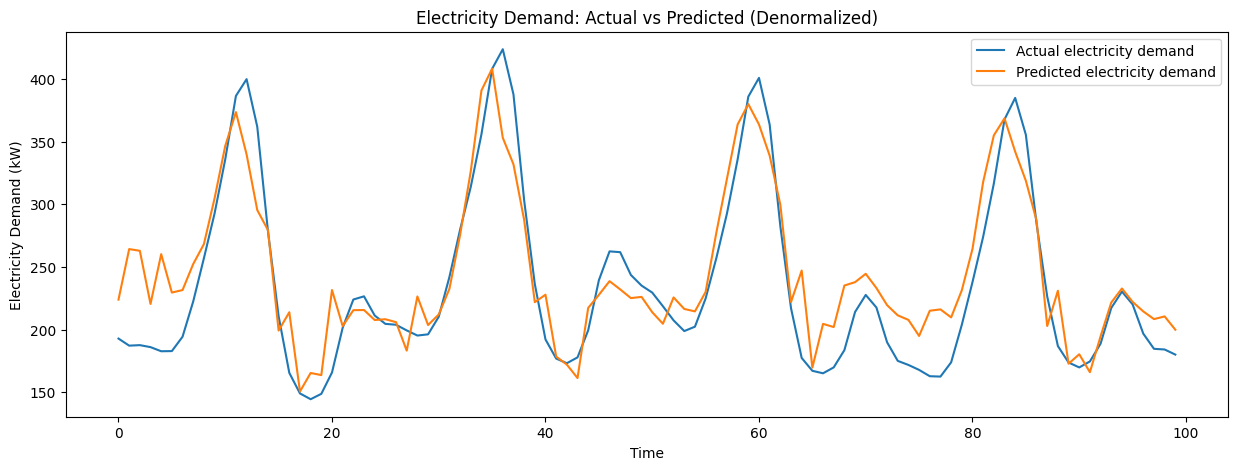

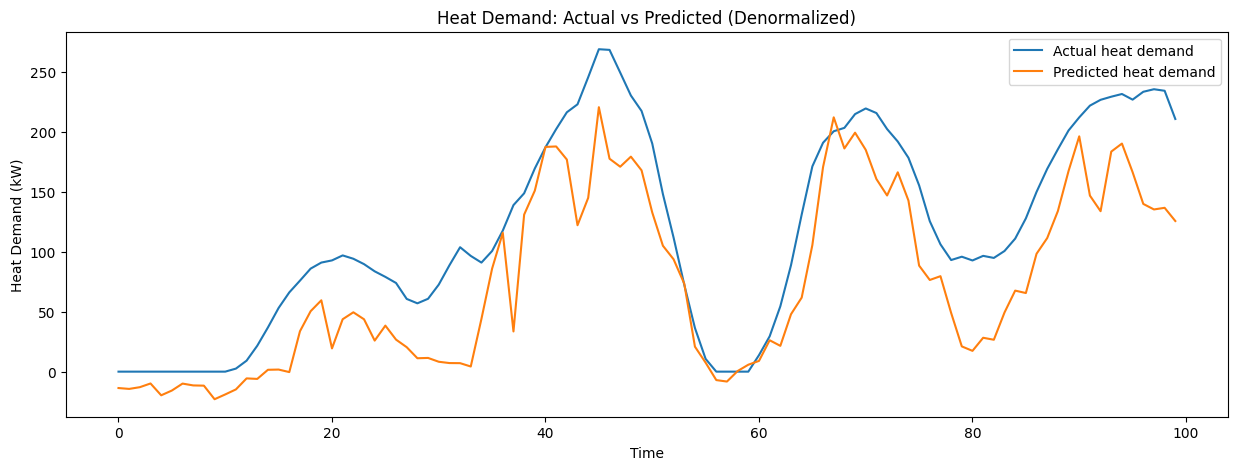

In [31]:
# Print some denormalized actual and predicted values for comparison
i_range = range(13731)

for i in i_range:
    print(f"Index {i}: Actual [electricity, heat] = [{y_test_denorm[i, 0]:.2f}, {y_test_denorm[i, 1]:.2f}], Predicted [electricity, heat] = [{y_pred_denorm[i, 0]:.2f}, {y_pred_denorm[i, 1]:.2f}]")

# Plot actual vs predicted values for denormalized data
plt.figure(figsize=(15, 5))
plt.plot(y_test_denorm[:100, 0], label="Actual electricity demand")
plt.plot(y_pred_denorm[:100, 0], label="Predicted electricity demand")
plt.title("Electricity Demand: Actual vs Predicted (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Electricity Demand (kW)")
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(y_test_denorm[:100, 1], label="Actual heat demand")
plt.plot(y_pred_denorm[:100, 1], label="Predicted heat demand")
plt.title("Heat Demand: Actual vs Predicted (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Heat Demand (kW)")
plt.legend()
plt.show()


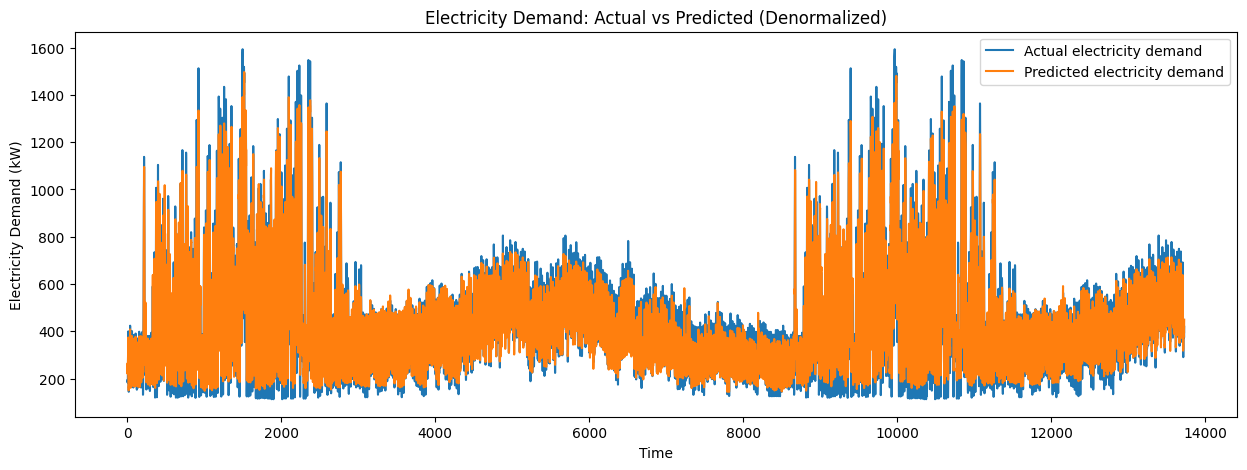

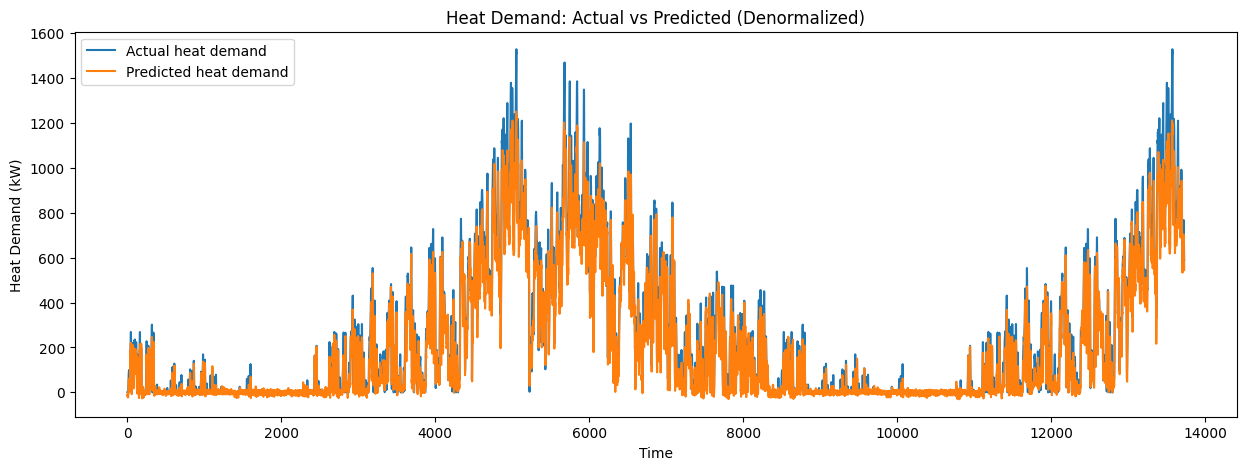

In [32]:
# Plot actual vs predicted values for denormalized data
plt.figure(figsize=(15, 5))
plt.plot(y_test_denorm[:14000, 0], label="Actual electricity demand")
plt.plot(y_pred_denorm[:14000, 0], label="Predicted electricity demand")
plt.title("Electricity Demand: Actual vs Predicted (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Electricity Demand (kW)")
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(y_test_denorm[:14000, 1], label="Actual heat demand")
plt.plot(y_pred_denorm[:14000, 1], label="Predicted heat demand")
plt.title("Heat Demand: Actual vs Predicted (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Heat Demand (kW)")
plt.legend()
plt.show()

In [33]:
import pandas as pd

# Create a DataFrame with denormalized actual and predicted values
results = pd.DataFrame({"Index": range(len(y_test_denorm)),
                        "Actual_electricity": y_test_denorm[:, 0],
                        "Actual_heat": y_test_denorm[:, 1],
                        "Predicted_electricity": y_pred_denorm[:, 0],
                        "Predicted_heat": y_pred_denorm[:, 1]})

# Save the DataFrame as an Excel file
results.to_excel("actual_vs_predicted.xlsx", index=False)
